In [3]:
# import necessary libraries
import yaml
from langchain import hub
# from langsmith import traceable
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

In [4]:

import os 

os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "testing_financial_agent"

In [5]:
# Read the config file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

# Portfolio Manager Agent

In [6]:
#load portfolio manager agent tools
from agent_tools.portfolio_manager_tools import place_order, get_portfolio_state

model_portfolio_manager = ChatOpenAI(
    model=config['models']['portfolio_manager']['model'], 
    temperature=config['models']['portfolio_manager']['temperature']
)

prompt_portfolio_manager = hub.pull(
    config['models']['portfolio_manager']['prompt_handler']
)[0].prompt.template

name_portfolio_manager_agent = config['models']['portfolio_manager']['agent_name']


portfolio_manager_agent = create_react_agent(
    model=model_portfolio_manager,
    tools=[place_order, get_portfolio_state],
    name=name_portfolio_manager_agent,
    prompt=prompt_portfolio_manager
)

# Financial Analyst Agent

In [7]:
from agent_tools.financial_analyst_tools import get_analyst_price_targets, get_recommendations
from agent_tools.financial_analyst_tools import get_fundamental_analysis, get_technical_analysis


model_financial_analyst = ChatOpenAI(
    model=config['models']['financial_analyst']['model'], 
    temperature=config['models']['financial_analyst']['temperature']
)

prompt_financial_analyst = hub.pull(
    config['models']['financial_analyst']['prompt_handler']
)[0].prompt.template

name_financial_analyst_agent = config['models']['financial_analyst']['agent_name']



financial_analyst_agent = create_react_agent(

    model=model_financial_analyst,
    tools=[
        get_analyst_price_targets,  
        get_recommendations,  
        get_fundamental_analysis,
        get_technical_analysis
    ],
    name=name_financial_analyst_agent,
    prompt=prompt_financial_analyst
)

# Company Research Agent

In [8]:
from agent_tools.company_research_tools import get_basic_info, get_quarterly_report
from agent_tools.company_research_tools import search_financial_news, get_balance_sheet

model_company_researcher = ChatOpenAI(
    model=config['models']['company_researcher']['model'], 
    temperature=config['models']['company_researcher']['temperature']
)

prompt_company_researcher = hub.pull(
    config['models']['company_researcher']['prompt_handler']
)[0].prompt.template

name_company_researcher = config['models']['company_researcher']['agent_name']


research_agent = create_react_agent(

    model=model_company_researcher,
    tools=[
        get_basic_info,  
        get_quarterly_report,  
        search_financial_news,
        get_balance_sheet
    ],
    name=name_company_researcher,
    prompt=prompt_company_researcher
)


# Orchestrator Agent

In [9]:
# Create supervisor workflow
model_orchestrator = ChatOpenAI(
    model=config['models']['orchestrator']['model'], 
    temperature=config['models']['orchestrator']['temperature']
)

prompt_orchestrator = hub.pull(
    config['models']['orchestrator']['prompt_handler']
)[0].prompt.template

name_orchestrator = config['models']['orchestrator']['agent_name']

workflow = create_supervisor(
    [portfolio_manager_agent, research_agent, financial_analyst_agent],
    model=model_orchestrator,
    prompt=(
        prompt_orchestrator
    )
)

# Compile and run
graph = workflow.compile()


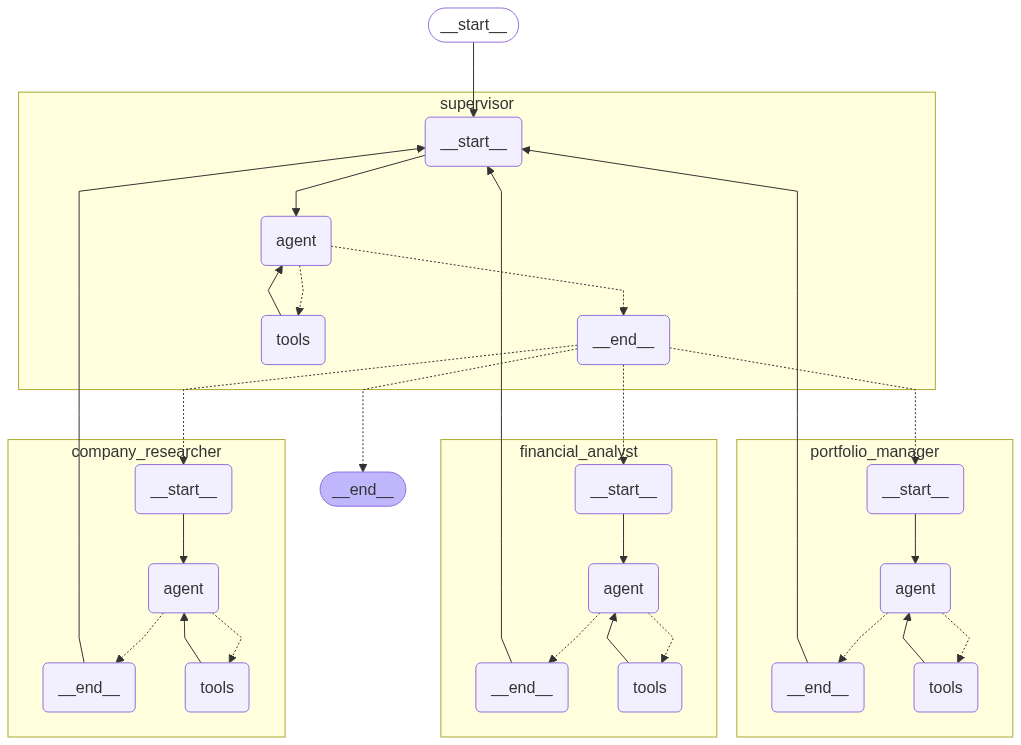

In [10]:
from IPython.display import Image, display


try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    graph.get_graph().print_ascii()





# Testing Portfolio Manager Agent

In [11]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "What is the current state of my portfolio?"
        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the current state of my portfolio?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_portfolio_manager (call_7ZZDKO8Oce3BgNaZOIeM9BEp)
 Call ID: call_7ZZDKO8Oce3BgNaZOIeM9BEp
  Args:
================================= Tool Message =================================
Name: transfer_to_portfolio_manager

Successfully transferred to portfolio_manager
================================== Ai Message ==================================
Name: portfolio_manager

Here's the current state of your portfolio:

- **Cash:** $55,987.73
- **Buying Power:** $175,197.96
- **Portfolio Value:** $119,210.23
- **Equity:** $119,210.23

### Positions:
1. **Microsoft (MSFT)**
   - Quantity: 50 shares
   - Average Entry Price: $352.41
   - Current Price: $458.17
   - Market Value: $22,908.50
   - Unrealized Profit/Loss: $5,287.86 (30.01%)

2. **NVIDIA (NVD

# Testing Research Agent

In [12]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Please provide me with the latest financial news about Pfizer"
        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Please provide me with the latest financial news about Pfizer
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_company_researcher (call_i8rekjExV7Z0c5sJsGHCxoTA)
 Call ID: call_i8rekjExV7Z0c5sJsGHCxoTA
  Args:
================================= Tool Message =================================
Name: transfer_to_company_researcher

Successfully transferred to company_researcher
================================== Ai Message ==================================
Name: company_researcher

Here are the latest financial news highlights about Pfizer:

1. **Stock Performance**: Pfizer (PFE) recently closed a trading day at $22.15, marking a 0.48% increase from the previous session.

2. **Regulatory News**: The U.S. Food and Drug Administration (FDA) has announced new regulatory guidelines for future COVID-19 vaccines and booster shots. This news 

# Test Financial Analyst

In [13]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            # "content": "Give me the fundamental analysis of Google"
            "content": "Give me analyst price targets for Google"

        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me analyst price targets for Google
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_financial_analyst (call_xM4kmpRVLQlTlUGm14Kuu73U)
 Call ID: call_xM4kmpRVLQlTlUGm14Kuu73U
  Args:
================================= Tool Message =================================
Name: transfer_to_financial_analyst

Successfully transferred to financial_analyst
================================== Ai Message ==================================
Name: financial_analyst

The analyst price targets for Google (GOOGL) are as follows:

- **Current Price:** $163.98
- **High Target:** $240.00
- **Low Target:** $160.00
- **Mean Target:** $200.56
- **Median Target:** $200.00

These targets provide a range of expectations from analysts regarding Google's future stock price.
================================== Ai Message ==================================
Name